In [57]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

print('...')

...


In [58]:
car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

(8792, 8968)


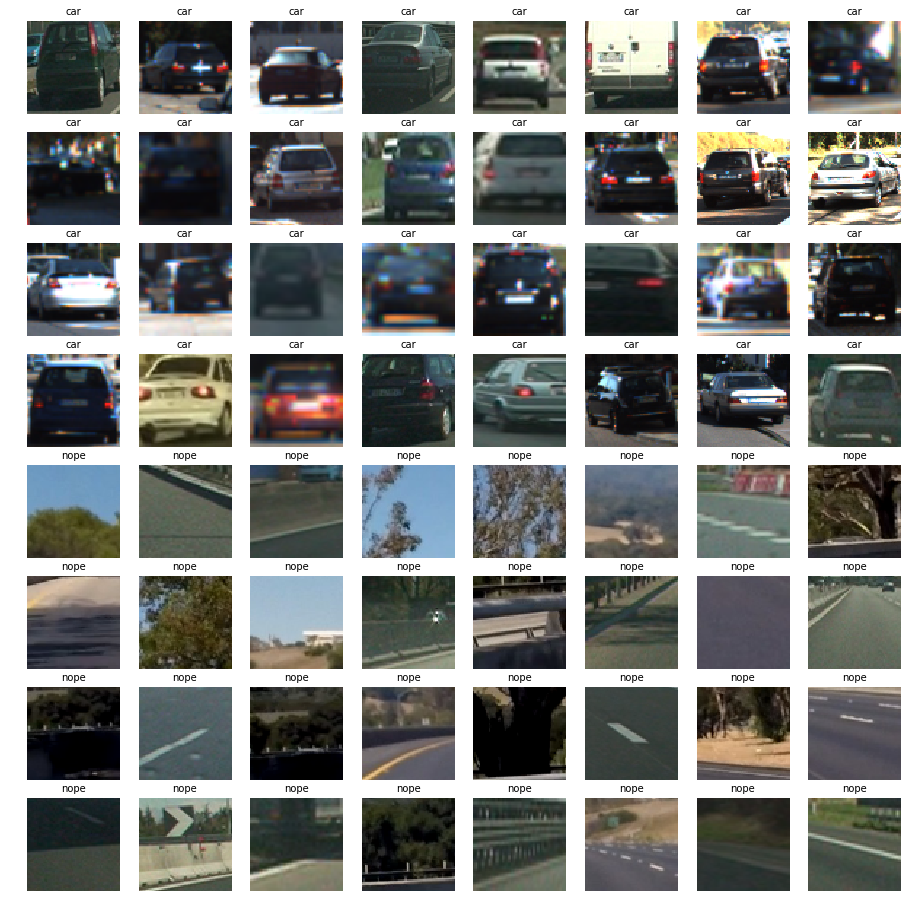

In [59]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)


In [60]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


In [61]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


...


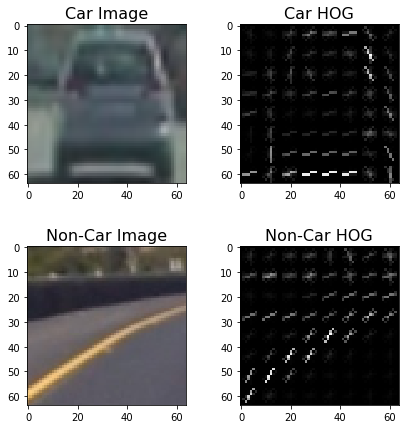

In [62]:
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

In [63]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('...')


...


In [64]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
min_max_scaler = preprocessing.MinMaxScaler().fit(X_train[0]); 

(74.87, 'Seconds to extract HOG features...')
('Using:', 11, 'orientations', 16, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 1188)


In [65]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(1.26, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9809)
('My SVC predicts: ', array([ 0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.]))
('For these', 10, 'labels: ', array([ 0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.]))
(0.00313, 'Seconds to predict', 10, 'labels with SVC')


# FIND CARS IN IMAGE

...


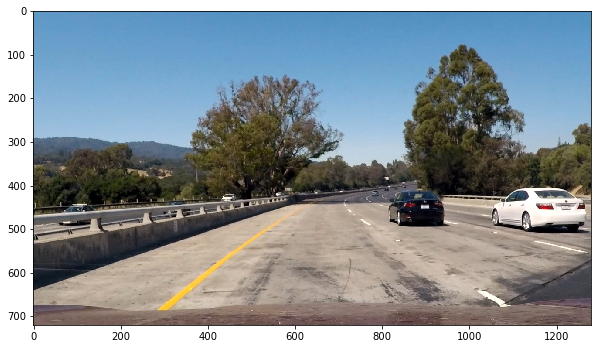

In [66]:
#read the road image 
test_img = mpimg.imread('./test_images/test1.jpg')
plt.figure(figsize=(10,10))
plt.imshow(test_img)
print('...')

In [67]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


In [68]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

...


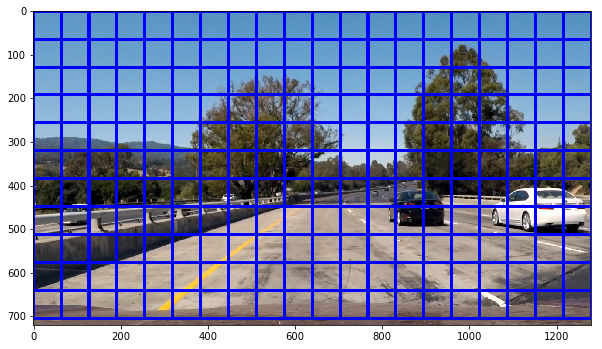

In [69]:
window_list = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
image_with_boxes = draw_boxes(test_img,window_list, color=(0, 0, 255), thick=6)
plt.figure(figsize=(10,10))
plt.imshow(image_with_boxes)
print('...')

In [70]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

...


In [71]:
ystart = 400
ystop = 656
scale = 2.0
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')


(4, 'rectangles found in image')


...


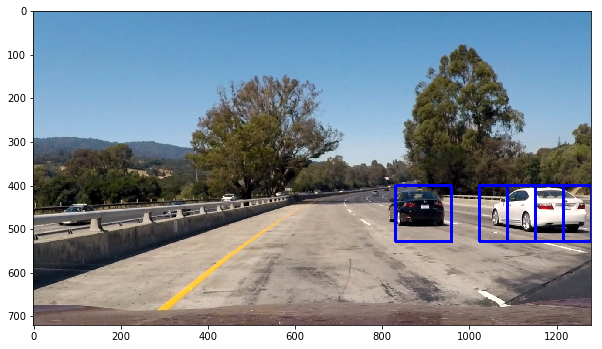

In [72]:
image_with_boxes = draw_boxes(test_img,rectangles, color=(0, 0, 255), thick=6)
plt.figure(figsize=(10,10))
plt.imshow(image_with_boxes)
print('...')

In [73]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')


...


In [74]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


In [75]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects



In [76]:
rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
print('...')

...


In [77]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


...


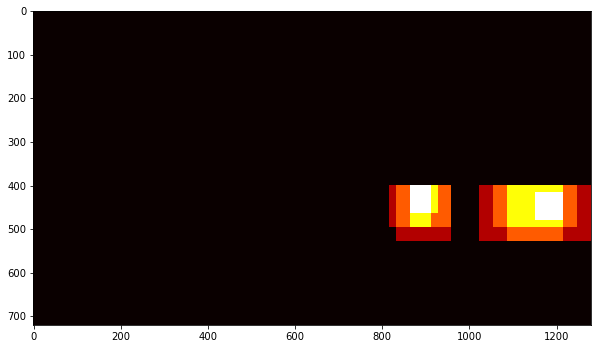

In [78]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

(2, 'cars found')


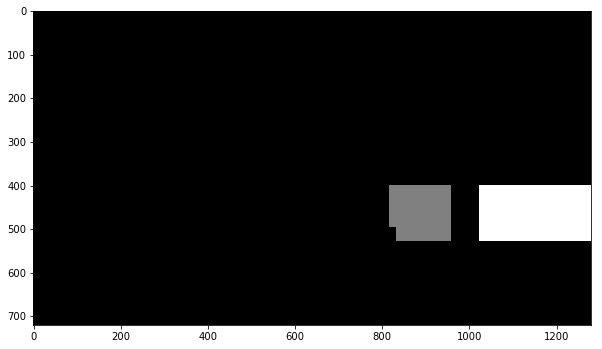

In [79]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

...


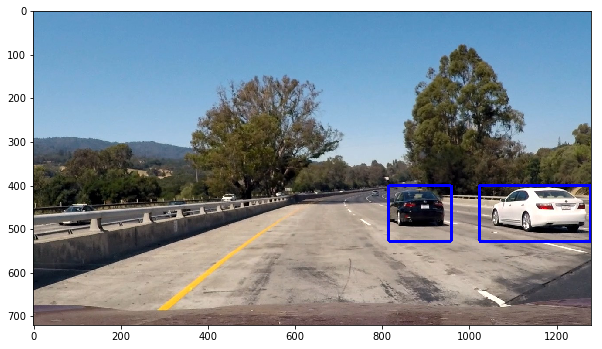

In [80]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

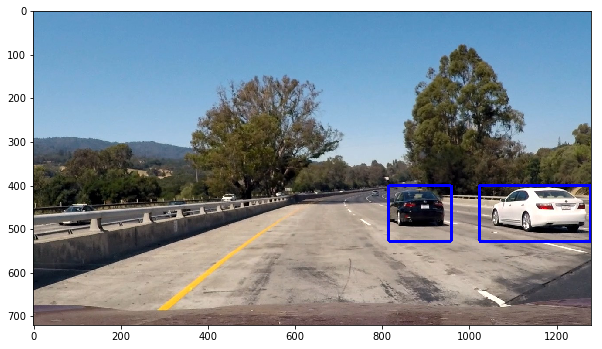

In [81]:
draw_img, rects = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [82]:
def processVideoFrame(img):
    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [83]:
test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(processVideoFrame)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:16,  2.32it/s]

  5%|▌         | 2/39 [00:00<00:16,  2.31it/s]

  8%|▊         | 3/39 [00:01<00:15,  2.33it/s]

 10%|█         | 4/39 [00:01<00:15,  2.31it/s]

 13%|█▎        | 5/39 [00:02<00:14,  2.32it/s]

 15%|█▌        | 6/39 [00:02<00:14,  2.32it/s]

 18%|█▊        | 7/39 [00:03<00:13,  2.31it/s]

 21%|██        | 8/39 [00:03<00:13,  2.32it/s]

 23%|██▎       | 9/39 [00:03<00:12,  2.33it/s]

 26%|██▌       | 10/39 [00:04<00:12,  2.33it/s]

 28%|██▊       | 11/39 [00:04<00:11,  2.35it/s]

 31%|███       | 12/39 [00:05<00:11,  2.34it/s]

 33%|███▎      | 13/39 [00:05<00:11,  2.32it/s]

 36%|███▌      | 14/39 [00:06<00:10,  2.31it/s]

 38%|███▊      | 15/39 [00:06<00:10,  2.30it/s]

 41%|████      | 16/39 [00:06<00:09,  2.32it/s]

 44%|████▎     | 17/39 [00:07<00:09,  2.34it/s]

 46%|████▌     | 18/39 [00:07<00:09,  2.29it/s]

 49%|████▊     | 19/39 [00:08<00:08,  2.31it/s]

 51%|█████▏    | 20/39 [00:08<00:08,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 14.4 s, sys: 2.46 s, total: 16.9 s
Wall time: 18.7 s


In [84]:
test_out_file2 = 'project_video_output1.mp4'
clip_test2 = VideoFileClip('project_video.mp4')
clip_test_out2 = clip_test2.fl_image(processVideoFrame)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:43,  2.40it/s]

  0%|          | 2/1261 [00:00<08:48,  2.38it/s]

  0%|          | 3/1261 [00:01<08:51,  2.37it/s]

  0%|          | 4/1261 [00:01<08:53,  2.36it/s]

  0%|          | 5/1261 [00:02<08:46,  2.39it/s]

  0%|          | 6/1261 [00:02<08:43,  2.40it/s]

  1%|          | 7/1261 [00:02<08:40,  2.41it/s]

  1%|          | 8/1261 [00:03<08:41,  2.40it/s]

  1%|          | 9/1261 [00:03<08:50,  2.36it/s]

  1%|          | 10/1261 [00:04<08:45,  2.38it/s]

  1%|          | 11/1261 [00:04<08:40,  2.40it/s]

  1%|          | 12/1261 [00:05<08:35,  2.42it/s]

  1%|          | 13/1261 [00:05<08:32,  2.43it/s]

  1%|          | 14/1261 [00:05<08:31,  2.44it/s]

  1%|          | 15/1261 [00:06<08:33,  2.43it/s]

  1%|▏         | 16/1261 [00:06<08:39,  2.40it/s]

  1%|▏         | 17/1261 [00:07<08:49,  2.35it/s]

  1%|▏         | 18/1261 [00:07<08:57,  2.31it/s]

  2%|▏         | 19/1261 [00:07<08:52,  2.33it/

 11%|█▏        | 143/1261 [01:05<08:20,  2.23it/s]

 11%|█▏        | 144/1261 [01:05<08:17,  2.25it/s]

 11%|█▏        | 145/1261 [01:05<08:00,  2.32it/s]

 12%|█▏        | 146/1261 [01:06<07:54,  2.35it/s]

 12%|█▏        | 147/1261 [01:06<08:01,  2.31it/s]

 12%|█▏        | 148/1261 [01:07<08:15,  2.25it/s]

 12%|█▏        | 149/1261 [01:07<08:08,  2.27it/s]

 12%|█▏        | 150/1261 [01:08<08:24,  2.20it/s]

 12%|█▏        | 151/1261 [01:08<09:46,  1.89it/s]

 12%|█▏        | 152/1261 [01:09<09:24,  1.97it/s]

 12%|█▏        | 153/1261 [01:09<08:56,  2.07it/s]

 12%|█▏        | 154/1261 [01:10<08:33,  2.16it/s]

 12%|█▏        | 155/1261 [01:10<08:14,  2.24it/s]

 12%|█▏        | 156/1261 [01:11<08:02,  2.29it/s]

 12%|█▏        | 157/1261 [01:11<07:50,  2.35it/s]

 13%|█▎        | 158/1261 [01:11<07:42,  2.38it/s]

 13%|█▎        | 159/1261 [01:12<07:45,  2.37it/s]

 13%|█▎        | 160/1261 [01:12<07:45,  2.37it/s]

 13%|█▎        | 161/1261 [01:13<07:49,  2.34it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [02:09<07:06,  2.29it/s]

 23%|██▎       | 285/1261 [02:09<07:04,  2.30it/s]

 23%|██▎       | 286/1261 [02:10<07:02,  2.31it/s]

 23%|██▎       | 287/1261 [02:10<06:58,  2.33it/s]

 23%|██▎       | 288/1261 [02:11<06:58,  2.32it/s]

 23%|██▎       | 289/1261 [02:11<07:02,  2.30it/s]

 23%|██▎       | 290/1261 [02:11<06:59,  2.31it/s]

 23%|██▎       | 291/1261 [02:12<07:12,  2.24it/s]

 23%|██▎       | 292/1261 [02:12<07:52,  2.05it/s]

 23%|██▎       | 293/1261 [02:13<08:10,  1.97it/s]

 23%|██▎       | 294/1261 [02:13<07:49,  2.06it/s]

 23%|██▎       | 295/1261 [02:14<07:30,  2.14it/s]

 23%|██▎       | 296/1261 [02:14<07:18,  2.20it/s]

 24%|██▎       | 297/1261 [02:15<07:09,  2.24it/s]

 24%|██▎       | 298/1261 [02:15<07:22,  2.17it/s]

 24%|██▎       | 299/1261 [02:16<07:20,  2.18it/s]

 24%|██▍       | 300/1261 [02:16<07:10,  2.23it/s]

 24%|██▍       | 301/1261 [02:17<07:00,  2.29it/s]

 24%|██▍       | 302/1261 [02:17<07:01,  2.27it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [03:15<06:28,  2.15it/s]

 34%|███▍      | 426/1261 [03:15<06:48,  2.05it/s]

 34%|███▍      | 427/1261 [03:16<06:32,  2.12it/s]

 34%|███▍      | 428/1261 [03:16<06:23,  2.17it/s]

 34%|███▍      | 429/1261 [03:17<06:15,  2.21it/s]

 34%|███▍      | 430/1261 [03:17<06:12,  2.23it/s]

 34%|███▍      | 431/1261 [03:18<06:14,  2.22it/s]

 34%|███▍      | 432/1261 [03:18<06:21,  2.17it/s]

 34%|███▍      | 433/1261 [03:19<06:23,  2.16it/s]

 34%|███▍      | 434/1261 [03:19<06:23,  2.16it/s]

 34%|███▍      | 435/1261 [03:20<06:45,  2.04it/s]

 35%|███▍      | 436/1261 [03:20<06:38,  2.07it/s]

 35%|███▍      | 437/1261 [03:21<06:54,  1.99it/s]

 35%|███▍      | 438/1261 [03:21<07:29,  1.83it/s]

 35%|███▍      | 439/1261 [03:22<07:31,  1.82it/s]

 35%|███▍      | 440/1261 [03:22<07:31,  1.82it/s]

 35%|███▍      | 441/1261 [03:23<07:03,  1.94it/s]

 35%|███▌      | 442/1261 [03:23<06:50,  2.00it/s]

 35%|███▌      | 443/1261 [03:24<06:51,  1.99it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [04:18<05:04,  2.28it/s]

 45%|████▍     | 567/1261 [04:19<05:02,  2.29it/s]

 45%|████▌     | 568/1261 [04:19<05:04,  2.28it/s]

 45%|████▌     | 569/1261 [04:20<05:02,  2.29it/s]

 45%|████▌     | 570/1261 [04:20<04:58,  2.31it/s]

 45%|████▌     | 571/1261 [04:21<04:59,  2.30it/s]

 45%|████▌     | 572/1261 [04:21<05:03,  2.27it/s]

 45%|████▌     | 573/1261 [04:21<05:00,  2.29it/s]

 46%|████▌     | 574/1261 [04:22<04:55,  2.33it/s]

 46%|████▌     | 575/1261 [04:22<04:51,  2.35it/s]

 46%|████▌     | 576/1261 [04:23<04:54,  2.32it/s]

 46%|████▌     | 577/1261 [04:23<05:01,  2.27it/s]

 46%|████▌     | 578/1261 [04:24<04:55,  2.31it/s]

 46%|████▌     | 579/1261 [04:24<04:58,  2.29it/s]

 46%|████▌     | 580/1261 [04:24<05:00,  2.27it/s]

 46%|████▌     | 581/1261 [04:25<05:08,  2.20it/s]

 46%|████▌     | 582/1261 [04:25<05:01,  2.25it/s]

 46%|████▌     | 583/1261 [04:26<04:58,  2.27it/s]

 46%|████▋     | 584/1261 [04:26<04:58,  2.27it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [05:21<04:04,  2.27it/s]

 56%|█████▌    | 708/1261 [05:21<04:03,  2.27it/s]

 56%|█████▌    | 709/1261 [05:22<04:03,  2.27it/s]

 56%|█████▋    | 710/1261 [05:22<04:04,  2.25it/s]

 56%|█████▋    | 711/1261 [05:22<04:02,  2.27it/s]

 56%|█████▋    | 712/1261 [05:23<04:02,  2.27it/s]

 57%|█████▋    | 713/1261 [05:23<04:04,  2.24it/s]

 57%|█████▋    | 714/1261 [05:24<04:03,  2.25it/s]

 57%|█████▋    | 715/1261 [05:24<04:03,  2.24it/s]

 57%|█████▋    | 716/1261 [05:25<04:09,  2.18it/s]

 57%|█████▋    | 717/1261 [05:25<04:03,  2.23it/s]

 57%|█████▋    | 718/1261 [05:26<04:02,  2.24it/s]

 57%|█████▋    | 719/1261 [05:26<03:59,  2.27it/s]

 57%|█████▋    | 720/1261 [05:26<03:53,  2.31it/s]

 57%|█████▋    | 721/1261 [05:27<03:52,  2.32it/s]

 57%|█████▋    | 722/1261 [05:27<03:51,  2.32it/s]

 57%|█████▋    | 723/1261 [05:28<03:51,  2.33it/s]

 57%|█████▋    | 724/1261 [05:28<03:48,  2.35it/s]

 57%|█████▋    | 725/1261 [05:29<03:47,  2.35it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [06:23<03:02,  2.27it/s]

 67%|██████▋   | 849/1261 [06:23<03:25,  2.00it/s]

 67%|██████▋   | 850/1261 [06:24<03:25,  2.00it/s]

 67%|██████▋   | 851/1261 [06:25<03:37,  1.89it/s]

 68%|██████▊   | 852/1261 [06:25<03:34,  1.90it/s]

 68%|██████▊   | 853/1261 [06:26<03:36,  1.89it/s]

 68%|██████▊   | 854/1261 [06:26<03:35,  1.88it/s]

 68%|██████▊   | 855/1261 [06:27<03:39,  1.85it/s]

 68%|██████▊   | 856/1261 [06:27<03:32,  1.91it/s]

 68%|██████▊   | 857/1261 [06:28<03:32,  1.90it/s]

 68%|██████▊   | 858/1261 [06:28<03:29,  1.93it/s]

 68%|██████▊   | 859/1261 [06:29<03:33,  1.88it/s]

 68%|██████▊   | 860/1261 [06:29<03:26,  1.94it/s]

 68%|██████▊   | 861/1261 [06:30<03:22,  1.97it/s]

 68%|██████▊   | 862/1261 [06:30<03:21,  1.98it/s]

 68%|██████▊   | 863/1261 [06:31<03:28,  1.91it/s]

 69%|██████▊   | 864/1261 [06:31<03:19,  1.99it/s]

 69%|██████▊   | 865/1261 [06:32<03:10,  2.08it/s]

 69%|██████▊   | 866/1261 [06:32<03:23,  1.95it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [07:28<02:16,  1.99it/s]

 79%|███████▊  | 990/1261 [07:28<02:16,  1.99it/s]

 79%|███████▊  | 991/1261 [07:29<02:10,  2.07it/s]

 79%|███████▊  | 992/1261 [07:29<02:07,  2.12it/s]

 79%|███████▊  | 993/1261 [07:30<02:05,  2.14it/s]

 79%|███████▉  | 994/1261 [07:30<02:02,  2.18it/s]

 79%|███████▉  | 995/1261 [07:31<02:01,  2.20it/s]

 79%|███████▉  | 996/1261 [07:31<02:03,  2.14it/s]

 79%|███████▉  | 997/1261 [07:32<02:02,  2.15it/s]

 79%|███████▉  | 998/1261 [07:32<02:01,  2.17it/s]

 79%|███████▉  | 999/1261 [07:32<01:59,  2.19it/s]

 79%|███████▉  | 1000/1261 [07:33<02:02,  2.12it/s]

 79%|███████▉  | 1001/1261 [07:33<02:05,  2.08it/s]

 79%|███████▉  | 1002/1261 [07:34<02:04,  2.08it/s]

 80%|███████▉  | 1003/1261 [07:34<02:01,  2.13it/s]

 80%|███████▉  | 1004/1261 [07:35<02:00,  2.14it/s]

 80%|███████▉  | 1005/1261 [07:35<01:58,  2.15it/s]

 80%|███████▉  | 1006/1261 [07:36<01:58,  2.15it/s]

 80%|███████▉  | 1007/1261 [07:36<01:59,  2.13it/s]

 80%

 89%|████████▉ | 1128/1261 [08:33<01:03,  2.09it/s]

 90%|████████▉ | 1129/1261 [08:34<01:01,  2.15it/s]

 90%|████████▉ | 1130/1261 [08:34<00:59,  2.20it/s]

 90%|████████▉ | 1131/1261 [08:35<00:58,  2.24it/s]

 90%|████████▉ | 1132/1261 [08:35<01:01,  2.09it/s]

 90%|████████▉ | 1133/1261 [08:36<01:00,  2.13it/s]

 90%|████████▉ | 1134/1261 [08:36<01:00,  2.10it/s]

 90%|█████████ | 1135/1261 [08:37<00:59,  2.13it/s]

 90%|█████████ | 1136/1261 [08:37<00:59,  2.11it/s]

 90%|█████████ | 1137/1261 [08:38<00:57,  2.18it/s]

 90%|█████████ | 1138/1261 [08:38<00:55,  2.22it/s]

 90%|█████████ | 1139/1261 [08:38<00:54,  2.25it/s]

 90%|█████████ | 1140/1261 [08:39<00:53,  2.28it/s]

 90%|█████████ | 1141/1261 [08:39<00:53,  2.26it/s]

 91%|█████████ | 1142/1261 [08:40<00:53,  2.24it/s]

 91%|█████████ | 1143/1261 [08:40<00:57,  2.06it/s]

 91%|█████████ | 1144/1261 [08:41<00:55,  2.10it/s]

 91%|█████████ | 1145/1261 [08:41<00:55,  2.08it/s]

 91%|█████████ | 1146/1261 [08:42<00:58,  1.98

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output1.mp4 

CPU times: user 8min 8s, sys: 1min 21s, total: 9min 29s
Wall time: 9min 34s
